**The Following Code is worked Correctly!!!!**

In [25]:
import os
import numpy as np
from PIL import Image

def is_jpeg(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

def get_subdirs(directory):
    subdirs = sorted([os.path.join(directory, name) for name in sorted(os.listdir(directory)) if os.path.isdir(os.path.join(directory, name))])
    return subdirs

class ExternalInputIterator:
    def __init__(self, imageset_dir, batch_size, random_shuffle=False):
        self.imageset_dir = imageset_dir
        self.batch_size = batch_size

        # Get subdirectories (assuming "pose" and "frontal" folders exist)
        #self.pose_dirs = get_subdirs(os.path.join(imageset_dir, "pose"))
        self.pose_dirs = os.path.join(imageset_dir, "pose")
        self.frontal_dir = os.path.join(imageset_dir, "frontal")
        print(self.frontal_dir)
        print(self.pose_dirs)

        # Collect profile image paths
        self.profile_files = []
        #for pose_dir in self.pose_dirs:
        profile_files = [os.path.join(self.pose_dirs, file) for file in sorted(os.listdir(self.pose_dirs)) if is_jpeg(file)]
        self.profile_files.extend(profile_files)
        print(len(self.profile_files))

        # Collect frontal image paths
        self.frontal_files = [os.path.join(self.frontal_dir, file) for file in sorted(os.listdir(self.frontal_dir)) if is_jpeg(file)]
        print(len(self.frontal_files))

        # Shuffle if necessary
        if random_shuffle:
            np.random.shuffle(self.profile_files)
            np.random.shuffle(self.frontal_files)

        self.i = 0
        self.n = len(self.profile_files)

    def __iter__(self):
        return self

    def __next__(self):
        profiles = []
        frontals = []

        for _ in range(self.batch_size):
            profile_filename = self.profile_files[self.i]
            frontal_filename = self.match_frontal_image(profile_filename)

            with Image.open(profile_filename) as profile_img:
                profiles.append(np.array(profile_img))
            with Image.open(frontal_filename) as frontal_img:
                frontals.append(np.array(frontal_img))

            self.i = (self.i + 1) % self.n

        return (profiles, frontals)

    def match_frontal_image(self, profile_filename):
        profile_name = os.path.basename(profile_filename).split("_")[1]
        for frontal_file in self.frontal_files:
            if profile_name in frontal_file:
                return frontal_file
        return None

class ImagePipeline:
    def __init__(self, imageset_dir, image_size=128, random_shuffle=False, batch_size=64,device_id = 0):
        self.eii = ExternalInputIterator(imageset_dir, batch_size, random_shuffle)
        self.iterator = iter(self.eii)
        self.num_inputs = len(self.eii.profile_files)
        self.image_size = image_size

    def epoch_size(self, name=None):
        return self.num_inputs

    def __len__(self):
        return self.num_inputs

    def __iter__(self):
        return self

    def __next__(self):
        (images, targets) = next(self.iterator)

        # Perform resizing and normalization using NumPy
        resized_images = np.array([np.array(Image.fromarray(img).resize((self.image_size, self.image_size))) for img in images])
        resized_targets = np.array([np.array(Image.fromarray(target).resize((self.image_size, self.image_size))) for target in targets])

        # Normalize using mean and standard deviation
        normalized_images = (resized_images - 128.0) / 128.0
        normalized_targets = (resized_targets - 128.0) / 128.0

        return (normalized_images, normalized_targets)

    def __getitem__(self, index):
        # Advance the iterator to the desired index
        for _ in range(index):
            next(self.iterator)

        # Return the next batch
        return next(self)


In [19]:
x = ExternalInputIterator(imageset_dir=r"C:\Users\zed\Dataset\mydata",batch_size=32)

C:\Users\zed\Dataset\mydata\frontal
C:\Users\zed\Dataset\mydata\pose
200
10


In [20]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.autograd import Variable


def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


''' Generator network for 128x128 RGB images '''
class G(nn.Module):
    
    def __init__(self):
        super(G, self).__init__()
        
        self.main = nn.Sequential(
            # Input HxW = 128x128
            nn.Conv2d(1, 16, 4, 2, 1), # Output HxW = 64x64
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 4, 2, 1), # Output HxW = 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), # Output HxW = 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1), # Output HxW = 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1), # Output HxW = 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1), # Output HxW = 2x2
            nn.MaxPool2d((2,2)),
            # At this point, we arrive at our low D representation vector, which is 512 dimensional.

            nn.ConvTranspose2d(512, 256, 4, 1, 0, bias = False), # Output HxW = 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False), # Output HxW = 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False), # Output HxW = 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias = False), # Output HxW = 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias = False), # Output HxW = 64x64
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 4, 2, 1, bias = False), # Output HxW = 128x128
            nn.Tanh()
        )

    
    def forward(self, input):
        output = self.main(input)
        return output


''' Discriminator network for 128x128 RGB images '''
class D(nn.Module):
    
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                                  nn.Conv2d(1, 16, 4, 2, 1),
                                  nn.LeakyReLU(0.2, inplace = True),
                                  nn.Conv2d(16, 32, 4, 2, 1),
                                  nn.BatchNorm2d(32),
                                  nn.LeakyReLU(0.2, inplace = True),
                                  nn.Conv2d(32, 64, 4, 2, 1),
                                  nn.BatchNorm2d(64),
                                  nn.LeakyReLU(0.2, inplace = True),
                                  nn.Conv2d(64, 128, 4, 2, 1),
                                  nn.BatchNorm2d(128),
                                  nn.LeakyReLU(0.2, inplace = True),
                                  nn.Conv2d(128, 256, 4, 2, 1),
                                  nn.BatchNorm2d(256),
                                  nn.LeakyReLU(0.2, inplace = True),
                                  nn.Conv2d(256, 512, 4, 2, 1),
                                  nn.BatchNorm2d(512),
                                  nn.LeakyReLU(0.2, inplace = True),
                                  nn.Conv2d(512, 1, 4, 2, 1, bias = False),
                                  nn.Sigmoid()
                                  )
    
    
    def forward(self, input):
        output = self.main(input)
        return output.view(-1)

In [24]:
from __future__ import print_function
import time
import math
import random
import os
from os import listdir
from os.path import join
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

#from nvidia.dali.plugin.pytorch import DALIGenericIterator

#from data import ImagePipeline
#import network

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
torch.cuda.manual_seed(999)
# Where is your training dataset at?
datapath =r"C:\Users\zed\Dataset\mydata"

# You can also choose which GPU you want your model to be trained on below:
gpu_id = 0
device = torch.device("cuda", gpu_id)

"""train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=30, device_id=gpu_id)
train_pipe.build()
m_train = train_pipe.epoch_size()
print("Size of the training set: ", m_train)
train_pipe_loader = DALIGenericIterator(train_pipe, ["profiles", "frontals"], m_train)"""
# Assuming you have the modified ImagePipeline class from the previous responses
train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=32, device_id=gpu_id)
# No need to call build() without DALI

# Use a standard PyTorch DataLoader instead of DALIGenericIterator
#train_pipe_loader = DataLoader(train_pipe, batch_size=train_pipe.batch_size)
m_train = train_pipe.epoch_size()
#train_pipe_loader = DataLoader(train_pipe, batch_size=32,)
train_pipe_loader = DataLoader(train_pipe,)
# Generator:
#netG = network.G().to(device)
#netG.apply(network.weights_init)
netG = G().to(device)
netG.apply(weights_init)

# Discriminator:
#netD = network.D().to(device)
#netD.apply(network.weights_init)
netD = D().to(device)
netD.apply(weights_init)

# Here is where you set how important each component of the loss function is:
L1_factor = 0
L2_factor = 1
GAN_factor = 0.0005

criterion = nn.BCELoss() # Binary cross entropy loss

# Optimizers for the generator and the discriminator (Adam is a fancier version of gradient descent with a few more bells and whistles that is used very often):
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999), eps = 1e-8)

# Create a directory for the output files
try:
    os.mkdir('output')
except OSError:
    pass

start_time = time.time()

# Let's train for 30 epochs (meaning, we go through the entire training set 30 times):
for epoch in range(3):
    
    # Lets keep track of the loss values for each epoch:
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    
    # Your train_pipe_loader will load the images one batch at a time
    # The inner loop iterates over those batches:
    print("starting...")
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch+1}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
        
        # These are your images from the current batch:
        #profile = data[0]['profiles']
        #frontal = data[0]['frontals']
            profile = data[0].view(32, 1, 128, 128)
            frontal = data[1].view(32, 1, 128, 128)
        
        
        # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            output = netD(real)
        # D should accept the GT images
            errD_real = criterion(output, target)
        
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            generated = netG(profile)
            target = Variable(torch.zeros(real.size()[0])).to(device)
            output = netD(generated.detach()) # detach() because we are not training G here

            pbar.update(1)
        
        # D should reject the synthetic images
            errD_fake = criterion(output, target)
        
            errD = errD_real + errD_fake
            errD.backward()
        # Update D
            optimizerD.step()
        
        # TRAINING THE GENERATOR
            netG.zero_grad()
            target = Variable(torch.ones(real.size()[0])).to(device)
            output = netD(generated)
        
        # G wants to :
        # (a) have the synthetic images be accepted by D (= look like frontal images of people)
            errG_GAN = criterion(output, target)
        
        # (b) have the synthetic images resemble the ground truth frontal image
            errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
        
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
        
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()
        
            errG.backward()
        # Update G
            optimizerG.step()
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    if epoch > 0:
        print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train,))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'output/netG_%d.pt' % epoch)

C:\Users\zed\Dataset\mydata\frontal
C:\Users\zed\Dataset\mydata\pose
200
10
starting...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [09:33<00:00,  2.87s/it]


First training epoch completed in  573.5028319358826  seconds
[1/30] Training absolute losses: L1 0.1250928 ; L2 0.0379307 BCE 4.1914748
starting...


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [09:17<00:00,  2.79s/it]


Epoch: 1 is starting..
[2/30] Training absolute losses: L1 0.0585486 ; L2 0.0065839 BCE 3.5193734
starting...


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [09:20<00:00,  2.80s/it]


Epoch: 2 is starting..
[3/30] Training absolute losses: L1 0.0503019 ; L2 0.0044936 BCE 3.1273609


**Edited to visualize the loss**

In [27]:
from __future__ import print_function
import time
import math
import random
import os
from os import listdir
from os.path import join
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

#from nvidia.dali.plugin.pytorch import DALIGenericIterator

#from data import ImagePipeline
#import network

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
torch.cuda.manual_seed(999)
# Where is your training dataset at?
datapath =r"C:\Users\zed\Dataset\mydata"

# You can also choose which GPU you want your model to be trained on below:
gpu_id = 0
device = torch.device("cuda", gpu_id)

"""train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=30, device_id=gpu_id)
train_pipe.build()
m_train = train_pipe.epoch_size()
print("Size of the training set: ", m_train)
train_pipe_loader = DALIGenericIterator(train_pipe, ["profiles", "frontals"], m_train)"""
# Assuming you have the modified ImagePipeline class from the previous responses
train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=32, device_id=gpu_id)
# No need to call build() without DALI

# Use a standard PyTorch DataLoader instead of DALIGenericIterator
#train_pipe_loader = DataLoader(train_pipe, batch_size=train_pipe.batch_size)
m_train = train_pipe.epoch_size()
#train_pipe_loader = DataLoader(train_pipe, batch_size=32,)
train_pipe_loader = DataLoader(train_pipe,)
# Generator:
#netG = network.G().to(device)
#netG.apply(network.weights_init)
netG = G().to(device)
netG.apply(weights_init)

# Discriminator:
#netD = network.D().to(device)
#netD.apply(network.weights_init)
netD = D().to(device)
netD.apply(weights_init)

# Here is where you set how important each component of the loss function is:
L1_factor = 0
L2_factor = 1
GAN_factor = 0.0005

criterion = nn.BCELoss() # Binary cross entropy loss

# Optimizers for the generator and the discriminator (Adam is a fancier version of gradient descent with a few more bells and whistles that is used very often):
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999), eps = 1e-8)

# Create a directory for the output files
try:
    os.mkdir('output')
except OSError:
    pass

start_time = time.time()

# Lists to store the losses
losses_L1 = []
losses_L2 = []
losses_gan = []

# Let's train for 30 epochs (meaning, we go through the entire training set 30 times):
for epoch in range(3):
    
    # Lets keep track of the loss values for each epoch:
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    
    # Your train_pipe_loader will load the images one batch at a time
    # The inner loop iterates over those batches:
    print("starting...")
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch+1}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
        
        # These are your images from the current batch:
        #profile = data[0]['profiles']
        #frontal = data[0]['frontals']
            profile = data[0].view(32, 1, 128, 128)
            frontal = data[1].view(32, 1, 128, 128)
        
        
        # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            output = netD(real)
        # D should accept the GT images
            errD_real = criterion(output, target)
        
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            generated = netG(profile)
            target = Variable(torch.zeros(real.size()[0])).to(device)
            output = netD(generated.detach()) # detach() because we are not training G here

            pbar.update(1)
        
        # D should reject the synthetic images
            errD_fake = criterion(output, target)
        
            errD = errD_real + errD_fake
            errD.backward()
        # Update D
            optimizerD.step()
        
        # TRAINING THE GENERATOR
            netG.zero_grad()
            target = Variable(torch.ones(real.size()[0])).to(device)
            output = netD(generated)
        
        # G wants to :
        # (a) have the synthetic images be accepted by D (= look like frontal images of people)
            errG_GAN = criterion(output, target)
        
        # (b) have the synthetic images resemble the ground truth frontal image
            errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
        
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
        
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()
        
            errG.backward()
        # Update G
            optimizerG.step()
            
    # Append the losses for this epoch to the respective lists
    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    if epoch > 0:
        print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train,))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'output/netG_%d.pt' % epoch)

C:\Users\zed\Dataset\mydata\frontal
C:\Users\zed\Dataset\mydata\pose
200
10
starting...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [09:27<00:00,  2.84s/it]


First training epoch completed in  567.092960357666  seconds
[1/30] Training absolute losses: L1 0.1250928 ; L2 0.0379307 BCE 4.1914748
starting...


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [09:17<00:00,  2.79s/it]


Epoch: 1 is starting..
[2/30] Training absolute losses: L1 0.0585486 ; L2 0.0065839 BCE 3.5193734
starting...


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [09:12<00:00,  2.76s/it]


Epoch: 2 is starting..
[3/30] Training absolute losses: L1 0.0503019 ; L2 0.0044936 BCE 3.1273609


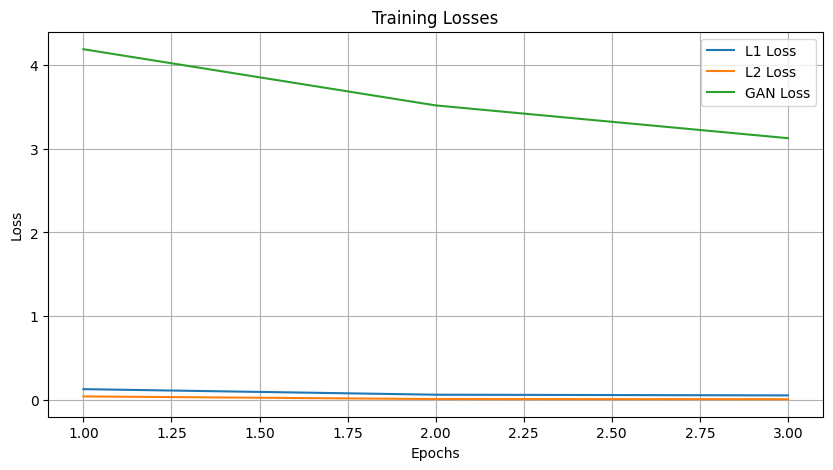

In [28]:
import matplotlib.pyplot as plt
# Plot the losses
epochs = range(1, 4)  # Assuming you trained for 3 epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses_L1, label='L1 Loss')
plt.plot(epochs, losses_L2, label='L2 Loss')
plt.plot(epochs, losses_gan, label='GAN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
import torch
import torchvision.utils as vutils
from torch.utils.data import DataLoader

torch.manual_seed(999)
torch.cuda.manual_seed(999)
#from data import ImagePipeline  # Assuming this custom class still exists

device = 'cuda'
datapath = r'C:\Users\zed\Dataset\CAS-PEAL-R1\test_data'

# Generate frontal images from the test set
def frontalize(model, datapath, mtest):
    
    test_pipe = ImagePipeline(datapath, image_size=128, batch_size = 3, random_shuffle=False)  # Removed batch_size
    test_pipe_loader = DataLoader(test_pipe, batch_size=mtest)  # Use DataLoader

    with torch.no_grad():
        for data in test_pipe_loader:
             
            profile = data[0].to(device).type(torch.float)  # Correct syntax to change data type
            print(profile.shape)
            profile = profile.view(3, 1, 128, 128) 
            print(profile.shape)
            generated = model(profile).type(torch.float)  # Convert output to float

            #profile = data[0].to(device)  # Assuming profiles are in data['profiles']
            #print("length:",len(profile))
            #generated = model(profile)
            vutils.save_image(torch.cat((profile, generated.data)), 'output/test.jpg', nrow=3, padding=2, normalize=True)  # Removed frontal for consistency

# Load a pre-trained Pytorch model
saved_model = torch.load("output/netG_1.pt")

frontalize(saved_model, datapath, 1)


C:\Users\zed\Dataset\CAS-PEAL-R1\test_data\frontal
C:\Users\zed\Dataset\CAS-PEAL-R1\test_data\pose
3
4
torch.Size([1, 3, 128, 128])
torch.Size([3, 1, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([3, 1, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([3, 1, 128, 128])
